# Week 7 

Download the LabMT wordlist. It’s available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.

Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

In [23]:
from pathlib import Path
import csv
import pandas as pd

path_to_word_list = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv"


def load_word_list(p: Path):
    
    p = Path(path_to_word_list)
    print("Path:", p)
    print("Exists:", p.exists())
    print("Absolute:", p.resolve())
    print("Current working dir:", Path.cwd())

    if not p.exists():
        print("\nFile not found. Check that the path is correct, the file is accessible, and that Dropbox sync hasn't moved it.")
        # show parent contents to help diagnose
        if p.parent.exists():
            print("\nFiles in parent directory (first 20):")
            for i, fp in enumerate(sorted(p.parent.iterdir())):
                if i >= 20:
                    break
                print(" ", fp.name)
    else:
        # try robust loading: prefer pandas if available, otherwise CSV reader
        try:
            df = pd.read_csv(p, encoding='utf-8', engine='python')
            print("\nCSV loaded with pandas. Shape:", df.shape)
            print("Columns:", list(df.columns))
            # choose word column (first) and score column (first numeric found after)
            # try to auto-detect relevant columns
            word_col_candidates = [c for c in df.columns if 'word' in c.lower()]
            score_col_candidates = [c for c in df.columns if 'happiness' in c.lower() or 'score' in c.lower()]

            if word_col_candidates:
                word_col = word_col_candidates[0]
            else:
                word_col = df.columns[0]  # fallback

            if score_col_candidates:
                score_col = score_col_candidates[0]
            else:
                # fallback: first numeric column
                num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
                score_col = num_cols[0] if num_cols else df.columns[1]

            print(f"Using columns: word='{word_col}', score='{score_col}'")

            w_l = dict(zip(df[word_col].astype(str).str.lower(), df[score_col].astype(float)))

            if score_col is None and df.shape[1] >= 2:
                score_col = df.columns[1]
            if score_col is None:
                raise ValueError("Could not find a score column in the CSV.")
            w_l = dict(zip(df[word_col].astype(str).str.lower(), df[score_col].astype(float)))
            print(f"Loaded {len(w_l)} words into w_l.")
        except Exception as e:
            print("Pandas load failed or not available, falling back to csv module. Error:", e)
            w_l = {}
            try:
                with open(p, 'r', encoding='utf-8') as f:
                    reader = csv.reader(f)
                    for row in reader:
                        if len(row) >= 2:
                            try:
                                word = row[0].strip().lower()
                                score = float(row[1])
                                w_l[word] = score
                            except:
                                continue
                print(f"Fallback: loaded {len(w_l)} words into w_l.")
            except Exception as e2:
                print("Fallback failed:", e2)
    return w_l


def calculate_sentiment(tokens, labmt_data=None):
    """
    Calculate average sentiment score for a list of tokens using LabMT word list
    
    Args:
        tokens (list): List of lowercase tokens/words
        labmt_data (dict, optional): Dictionary with word:score pairs from LabMT
        
    Returns:
        float: Average sentiment score of tokens found in LabMT
    """
    if labmt_data is None:
        # Default to loading the LabMT data
        # You'll need to adjust the path to your LabMT file
        labmt_path = "data/labmt_words.txt"
        labmt_data = {}
        with open(labmt_path, 'r', encoding='utf-8') as f:
            for line in f:
                word, score = line.strip().split('\t')
                labmt_data[word.lower()] = float(score)
    
    # Get scores for tokens that exist in labmt
    scores = [labmt_data[token] for token in tokens if token in labmt_data]
    
    # Return average if we found any scores, otherwise return neutral score (5.0)
    if scores:
        return sum(scores) / len(scores)
    return 5.0
w_l = load_word_list(Path(path_to_word_list))
# Example usage:
text_tokens = ['happy', 'wonderful', 'sad', 'amazing']
sentiment_score = calculate_sentiment(text_tokens, labmt_data=w_l)
print("Sentiment score:", sentiment_score)



Path: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv
Exists: True
Absolute: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv
Current working dir: c:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Mads

CSV loaded with pandas. Shape: (10187, 5)
Columns: ['Rank', 'Word', 'Word in English', 'Happiness Score', 'Standard Deviation of Ratings']
Using columns: word='Word', score='Happiness Score'
Loaded 10187 words into w_l.
Sentiment score: 6.525


In [24]:

from pathlib import Path
import json
import re
import networkx as nx
import nltk
nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize

# Paths
path_to_bands_folder = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Noa\Bands")
path_to_word_list = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv"

# Load the sentiment dictionary
w_l = load_word_list(Path(path_to_word_list))

path_to_graph = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Assignment1\rock_music_graph1.graphml"
# Load or create your graph
# (replace this with your actual graph)
# load the graph from file
G = nx.read_graphml(path_to_graph)

# Utility: simple tokenizer (split words, lowercase)

def tokenize(text):
    tokens = word_tokenize(text.lower())
    return [t for t in tokens if t.isalpha()]
# Iterate through band text files
for file in path_to_bands_folder.glob("*.txt"):
    try:
        # Extract band name from filename (e.g. "3 Doors Down.txt" → "3 Doors Down")
        band_name = file.stem.replace("_", " ")

        # Read file content
        text = file.read_text(encoding='utf-8')

        # Try parsing JSON (if stored in JSON format)
        try:
            data = json.loads(text)
            # Extract wikitext if it's stored under that structure
            text = data["query"]["pages"][next(iter(data["query"]["pages"]))]["revisions"][0]["slots"]["main"]["*"]
        except Exception:
            # not JSON or unexpected structure — keep as plain text
            pass

        # Tokenize text
        tokens = tokenize(text)

        # Calculate sentiment
        sentiment_score = calculate_sentiment(tokens, labmt_data=w_l)

        # Add node (if not already in graph)
        if band_name not in G:
            G.add_node(band_name)

        # Set sentiment as node attribute
        G.nodes[band_name]["sentiment"] = sentiment_score

        # print(f"{band_name:30s} → Sentiment: {sentiment_score:.2f}")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Check example
print("\nTotal nodes with sentiment:", sum("sentiment" in G.nodes[n] for n in G.nodes))




Path: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv
Exists: True
Absolute: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv
Current working dir: c:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Mads

CSV loaded with pandas. Shape: (10187, 5)
Columns: ['Rank', 'Word', 'Word in English', 'Happiness Score', 'Standard Deviation of Ratings']
Using columns: word='Word', score='Happiness Score'
Loaded 10187 words into w_l.

Total nodes with sentiment: 487


- Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.

- Remember histograms? Create a histogram of all of the artists’s associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.

- Who are the 10 artists with happiest and saddest pages?

Average sentiment: 5.573
Median sentiment: 5.577
Variance: 0.007
25th percentile: 5.535
75th percentile: 5.620


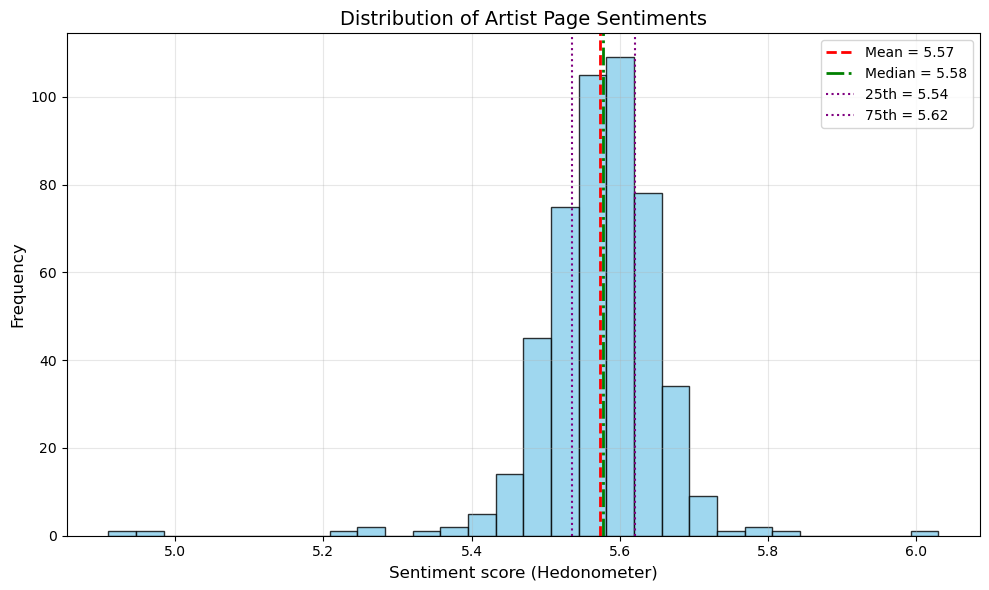

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Extract sentiment values from your graph
sentiments = nx.get_node_attributes(G, "sentiment")

# Convert to numpy array for easy stats
sentiment_values = np.array(list(sentiments.values()))

# Compute summary statistics
mean_val = np.mean(sentiment_values)
median_val = np.median(sentiment_values)
var_val = np.var(sentiment_values)
p25 = np.percentile(sentiment_values, 25)
p75 = np.percentile(sentiment_values, 75)

print(f"Average sentiment: {mean_val:.3f}")
print(f"Median sentiment: {median_val:.3f}")
print(f"Variance: {var_val:.3f}")
print(f"25th percentile: {p25:.3f}")
print(f"75th percentile: {p75:.3f}")

# Histogram
plt.figure(figsize=(10,6))
plt.hist(sentiment_values, bins=30, color="skyblue", edgecolor="black", alpha=0.8)
plt.title("Distribution of Artist Page Sentiments", fontsize=14)
plt.xlabel("Sentiment score (Hedonometer)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add vertical lines for summary stats
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")
plt.axvline(p25, color="purple", linestyle=":", linewidth=1.5, label=f"25th = {p25:.2f}")
plt.axvline(p75, color="purple", linestyle=":", linewidth=1.5, label=f"75th = {p75:.2f}")

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [26]:
# Sort bands by sentiment
sorted_bands = sorted(sentiments.items(), key=lambda x: x[1])

# 10 saddest
print("\n😢 10 Saddest artists:")
for band, val in sorted_bands[:10]:
    print(f"{band:30s}  {val:.2f}")

# 10 happiest
print("\n😄 10 Happiest artists:")
for band, val in sorted_bands[-10:][::-1]:  # reverse for descending
    print(f"{band:30s}  {val:.2f}")



😢 10 Saddest artists:
Poison  American band           4.91
England Dan   John Ford Coley   4.96
Jet  Australian band            5.24
Van Zant  band                  5.26
The B-52 s                      5.28
Five Finger Death Punch         5.32
Rage Against the Machine        5.37
Rob Zombie                      5.38
Echo   the Bunnymen             5.41
Marilyn Manson                  5.41

😄 10 Happiest artists:
Emerson  Lake   Palmer          6.03
Tracy Chapman                   5.82
Lenny Kravitz                   5.80
Boys Like Girls                 5.78
Fun  band                       5.75
Kenny Loggins                   5.72
Living Colour                   5.71
Michael Martin Murphey          5.71
Air Supply                      5.71
The Cardigans                   5.71
